In [28]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer
import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from canari import (
    DataProcess,
    Model,
    ModelOptimizer,
    SKF,
    SKFOptimizer,
    plot_data,
    plot_prediction,
    plot_skf_states,
    plot_states,
)
from canari.component import LocalTrend, LocalAcceleration, LstmNetwork, WhiteNoise
from matplotlib.ticker import MultipleLocator

In [29]:
param_optimization = False
num_trials = 100

In [30]:
data_file = "/Users/vuongdai/GitHub/canari/data/benchmark_data/test_10_data.csv"
df_raw = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time_series = pd.to_datetime(df_raw.iloc[:, 0])
df_raw = df_raw.iloc[:, 1:]
df_raw.index = time_series
df_raw.index.name = "date_time"
df_raw.columns = ["displacement_z", "water_level", "temp_min", "temp_max"]
lags = [0, 4, 4, 4]
df_raw = DataProcess.add_lagged_columns(df_raw, lags)
# Data pre-processing
output_col = [0]
data_processor = DataProcess(
    data=df_raw,
    time_covariates=["week_of_year"],
    train_split=0.27975,
    validation_split=0.054,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()
seed = np.random.randint(0, 100)

In [31]:
######### Define model with parameters #########
if param_optimization:
    smoother = True
    def model_with_parameters(param, train_data, validation_data):
        model = Model(
            LocalTrend(),
            LstmNetwork(
                look_back_len=int(param["look_back_len"]),
                num_features=17,
                num_layer=1,
                infer_len=52 * 3,
                num_hidden_unit=50,
                manual_seed=seed,
                smoother=smoother,
            ),
            WhiteNoise(std_error=param["sigma_v"]),
        )

        model.auto_initialize_baseline_states(train_data["y"][0 : 52 * 3])
        num_epoch = 50
        for epoch in range(num_epoch):
            mu_validation_preds, std_validation_preds, _ = model.lstm_train(
                train_data=train_data,
                validation_data=validation_data,
            )

            mu_validation_preds_unnorm = normalizer.unstandardize(
                mu_validation_preds,
                data_processor.scale_const_mean[data_processor.output_col],
                data_processor.scale_const_std[data_processor.output_col],
            )

            std_validation_preds_unnorm = normalizer.unstandardize_std(
                std_validation_preds,
                data_processor.scale_const_std[data_processor.output_col],
            )

            validation_obs = data_processor.get_data("validation").flatten()
            validation_log_lik = metric.log_likelihood(
                prediction=mu_validation_preds_unnorm,
                observation=validation_obs,
                std=std_validation_preds_unnorm,
            )

            model.early_stopping(
                evaluate_metric=-validation_log_lik,
                current_epoch=epoch,
                max_epoch=num_epoch,
            )
            model.metric_optim = model.early_stop_metric

            if model.stop_training:
                break

        #### Define SKF model with parameters #########

        abnorm_model = Model(
            LocalAcceleration(),
            LstmNetwork(),
            WhiteNoise(),
        )
        skf = SKF(
            norm_model=model,
            abnorm_model=abnorm_model,
            std_transition_error=param["std_transition_error"],
            norm_to_abnorm_prob=param["norm_to_abnorm_prob"],
        )

        skf.save_initial_states()

        filter_marginal_abnorm_prob, states, mu_preds, std_preds = skf.filter(
            data=all_data
        )

        mu_preds_unnorm = normalizer.unstandardize(
            mu_preds,
            data_processor.scale_const_mean[data_processor.output_col],
            data_processor.scale_const_std[data_processor.output_col],
        )

        std_preds_unnorm = normalizer.unstandardize_std(
            std_preds,
            data_processor.scale_const_std[data_processor.output_col],
        )

        obs_all = data_processor.get_data("all").flatten()
        log_lik_all = metric.log_likelihood(
            prediction=mu_preds_unnorm,
            observation=obs_all,
            std=std_preds_unnorm,
        )
        skf.metric_optim = -log_lik_all

        skf.load_initial_states()

        return skf, filter_marginal_abnorm_prob, states

In [32]:
if param_optimization:
    param_space = {
        "look_back_len": [12, 52],
        "sigma_v": [1e-3, 2e-1],
        "std_transition_error": [1e-6, 1e-4],
        "norm_to_abnorm_prob": [1e-6, 1e-4],
    }
    # Define optimizer
    model_optimizer = ModelOptimizer(
        model=model_with_parameters,
        param_space=param_space,
        train_data=train_data,
        validation_data=validation_data,
        num_optimization_trial=num_trials,
    )
    model_optimizer.optimize()
    # Get best model
    param = model_optimizer.get_best_param()
    skf_optim, filter_marginal_abnorm_prob, states = model_with_parameters(
        param, train_data, validation_data
    )

    skf_optim_dict = skf_optim.get_dict()
    skf_optim_dict["model_param"] = param
    skf_optim_dict["cov_names"] = train_data["cov_names"]
    with open("/Users/vuongdai/GitHub/canari/saved_params/benchmark_10_LL.pkl", "wb") as f:
        pickle.dump(skf_optim_dict, f)
else:
    with open("/Users/vuongdai/GitHub/canari/saved_params/benchmark_10_LL.pkl", "rb") as f:
        skf_optim_dict = pickle.load(f)
    skf_optim = SKF.load_dict(skf_optim_dict)

    print(skf_optim_dict["model_param"])

{'look_back_len': 22, 'sigma_v': 0.07524333152542781}


In [33]:
filter_marginal_abnorm_prob, states, *_ = skf_optim.filter(data=all_data)

In [34]:
# level_pos = states.get_mean(states_name="level", states_type="posterior")
# # level_pri = states.get_mean(states_name="level", states_type="prior")
# trend = states.get_mean(states_name="trend", states_type="posterior")

# diff_level = level_pos[1:] - level_pos[:-1]
# # shift 
# level_pos = level_pos[1:]
# # level_pri = level_pri[1:]
# trend = trend[:-1]
# # diff_level = np.insert(diff_level, 0, np.nan)
# ratio_diff_trend = diff_level/trend

level_pos = states.get_mean(states_name="level", states_type="posterior")
level_pri = states.get_mean(states_name="level", states_type="posterior")
trend = states.get_mean(states_name="trend", states_type="posterior")

diff_level = level_pri[1:] - level_pos[:-1]
# shift 
level_pos = level_pos[1:]
level_pri = level_pri[1:]
# trend = trend[1:]
trend = trend[:-1]
# diff_level = np.insert(diff_level, 0, np.nan)
ratio_diff_trend = diff_level-trend



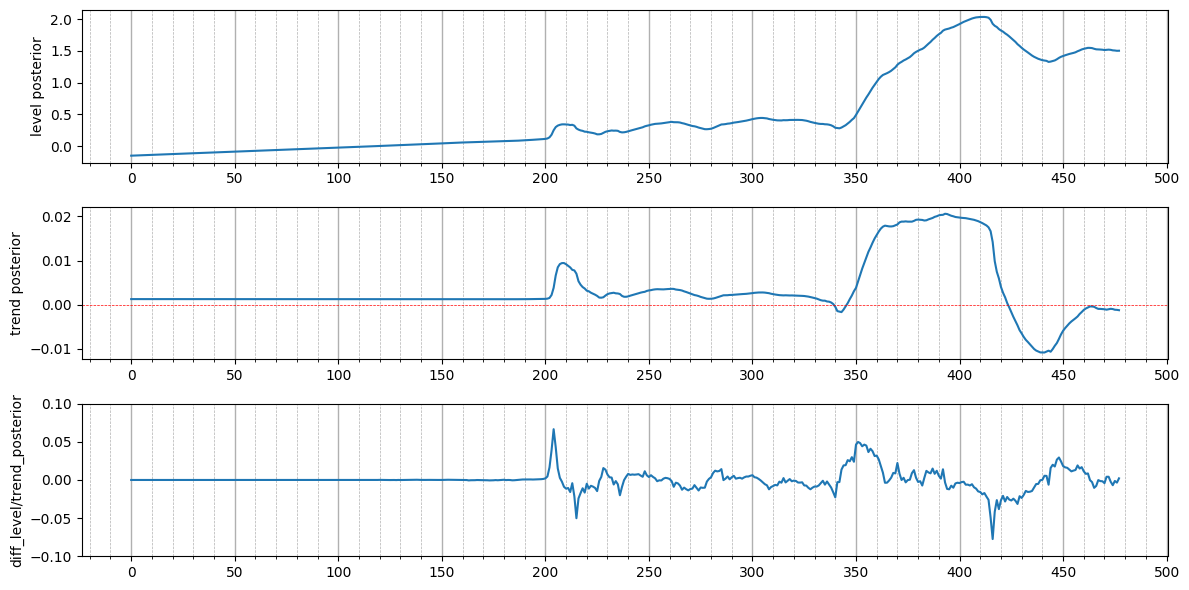

In [37]:
fig, ax = plt.subplots(3,1, figsize=(12,6))
ax[0].plot(level_pos)
ax[0].set_ylabel("level posterior")
ax[1].plot(trend)
ax[1].set_ylabel("trend posterior")
ax[1].axhline(0, color='red', linestyle="--", linewidth=0.5)
ax[2].plot(ratio_diff_trend)
ax[2].set_ylim(-0.1, .1)  
ax[2].set_ylabel("diff_level/trend_posterior")

# Set global x-range for all axes
for a in ax:
    a.xaxis.set_major_locator(MultipleLocator(50))
    a.xaxis.set_minor_locator(MultipleLocator(10))
    a.grid(which="major", axis="x", linestyle="-", linewidth=1)
    a.grid(which="minor", axis="x", linestyle="--", linewidth=0.5)

fig.tight_layout()
plt.show()

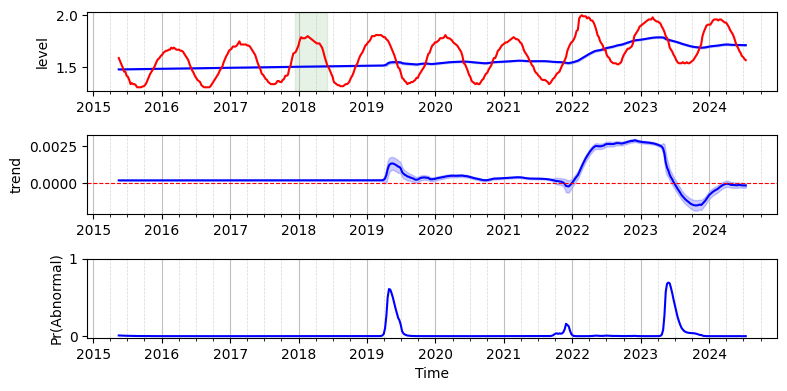

In [36]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    model_prob=filter_marginal_abnorm_prob,
    states_to_plot=["level", "trend"],
)
fig.set_size_inches(8, 4)   # width, height in inches
fig.tight_layout()
# plt.savefig("./saved_results/BM10_1.png")
plt.show()